#### Monte Carlo integration

Previously from Bayesian optimal tracking

* Prediction step

$$\begin{align*}
p(x_n|y_{0:n-1})=\int p(x_n| x_{n-1})p(x_{n-1}|y_{0:n-1})dx_{n-1}\\
\end{align*}$$

* Update step

$$p(x_n|y_{0:n})=\frac{p(y_n|x_n)}{p(y_n|y_{0:n-1})}p(x_n|y_{0:n-1})$$

we see that the integral in prediction step is really causing the headache, Monte Carlo (MC) integration is a possible way out of this

For the integral

$$\mu =\int g(x)dx$$

the idea of MC integration is first to factor $g(x)$ as $g(x)=f(x)p(x)$, where $p(x)$ is some PDF

$$p(x)\geq 0, \int p(x) dx =1$$

(and $p(x)>0$ wherever $g(x)>0$)

Then, by definition, this integral becomes expected value

$$\mu =\mathbb{E}[f(x)]$$

Suppose we can draw a large number of `independent` samples from $p(x)$, then, we can use samples to approximate the integral as

$$\begin{align*}
\mu&=\int g(x)dx \\
&=\int f(x) p(x) dx\\
&=\mathbb{E}[f(x)]\\
& \approx \hat{\mu}_N\\
&=\frac{1}{N}\sum_{i=1}^N f(x^i)
\end{align*}$$

where $x^i$ denotes the ith sample from $p(x)$

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
import time

plt.style.use('dark_background')
np.set_printoptions(formatter={'float': '{: 0.2e}'.format})

##### Mean estimation example

Suppose we have a random process

$$y=\cos(v), v\sim N(0, \sigma_v^2)$$

and we wish to estimate

$$\mathbb{E}[y]=\int \cos(v) p(v) dv$$

In [50]:
# Numerical integration
n_bin = 10000
sigma_v = 1
v = np.linspace(-10, 10, n_bin)
w_bin = v[1] - v[0]

def g(v, sigma_v=sigma_v):
    return np.cos(v) * norm.pdf(v, 0, sigma_v)

e_y_num = np.sum(g(v) * w_bin)
print(f'Numerical integration: {e_y_num}')

Numerical integration: 0.6065306597124


In [51]:
# MC integration
np.random.seed(42)

# To test different number of samples
n_sample = np.arange(1, 10000, 1)
mc_results = np.zeros_like(n_sample, dtype=float)

for idx, n in enumerate(n_sample):
    v_sample = np.random.normal(0, sigma_v, n)
    # Pointwise evaluation of cos(v), then take the mean
    mc_results[idx] = np.mean(np.cos(v_sample))

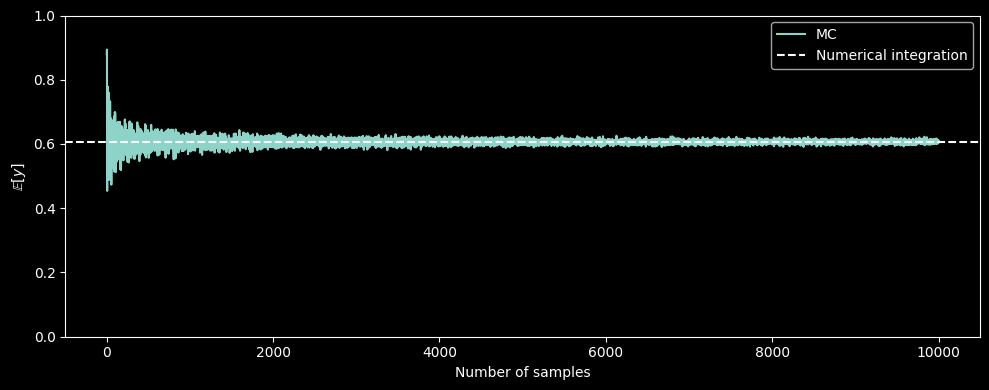

In [52]:
# Plot
fig_0, ax_0 = plt.subplots(figsize=(10,4))

ax_0.plot(n_sample, mc_results, '-', label='MC')
ax_0.set_xlabel('Number of samples')
ax_0.set_ylabel('$\mathbb{E}[y]$')
ax_0.set_ylim(0, 1)
ax_0.axhline(e_y_num, ls='--', label='Numerical integration')
ax_0.legend()

plt.tight_layout()
plt.show()

#### Importance sampling

For the integral that we are interested in

$$\begin{align*}
p(x_n|y_{0:n-1})=\int p(x_n| x_{n-1})p(x_{n-1}|y_{0:n-1})dx_{n-1}\\
\end{align*}$$

while it is already in the form of

$$\int f(x)p(x) dx$$

`efficiently` drawing samples from $p(x_{n-1}|y_{0:n-1})$ is not simple, even though we may be able to `evaluate it pointwise`

Assume that we could only draw samples efficiently from `standard` random number generator $q(x)$, we can rewrite the integral

$$\begin{align*}
\mu &=\int f(x) p(x) dx \\
&=\int \left[f(x)\frac{p(x)}{q(x)}\right]q(x) dx
\end{align*}$$

and our estimator becomes

$$\begin{align*}
\hat{\mu}_N &=\frac{1}{N}\sum_{i=1}^Nf(x^i)\frac{p(x^i)}{q(x^i)} \\
&=\frac{1}{N}\sum_{i=1}^Nf(x^i) \tilde{w}(x^i)
\end{align*}$$

where $\tilde{w}(x^i)=p(x^i)/q(x^i)$ are `unnormalized` weights

This stands if $q(x)>0$ everywhere $p(x)>0$, $q(x)$ is known as `importance density`

##### Mean estimation example

We revisit our mean estimation example

$$\mathbb{E}[y]=\int \cos(v) p(v) dv$$

and assume this time, we only have access to uniform number generator

In [53]:
np.random.seed(42)
n_sample = np.arange(1, 10000, 1)
mc_results = np.zeros_like(n_sample, dtype=float)

for idx, n in enumerate(n_sample):
    v_sample = np.random.uniform(-10, 10, n)
    # Pointwise evaluation of f(x)p(x)/q(x), then take the mean
    mc_results[idx] = np.mean(np.cos(v_sample) * norm.pdf(v_sample, 0, sigma_v)
                              / uniform.pdf(v_sample, -10, 20)) # [loc, loc + scale]

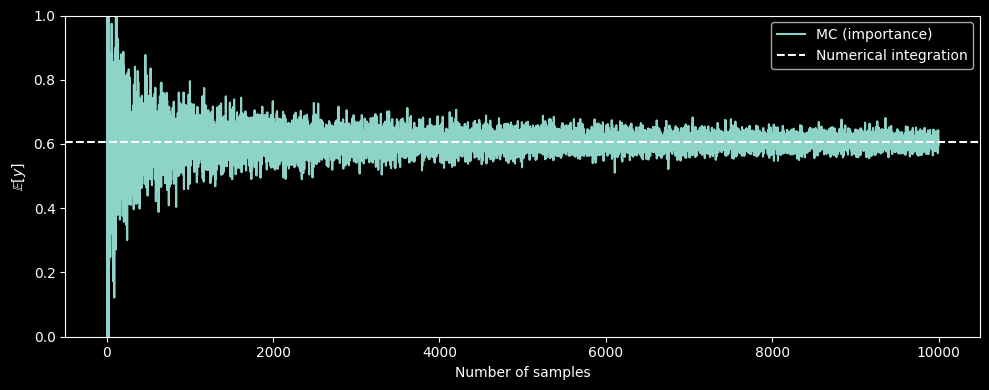

In [54]:
fig_1, ax_1 = plt.subplots(figsize=(10,4))

ax_1.plot(n_sample, mc_results, '-', label='MC (importance)')
ax_1.set_xlabel('Number of samples')
ax_1.set_ylabel('$\mathbb{E}[y]$')
ax_1.set_ylim(0, 1)
ax_1.axhline(e_y_num, ls='--', label='Numerical integration')
ax_1.legend()

plt.tight_layout()
plt.show()

#### Weight normalization

In many cases, for

$$\int f(x)p(x) dx$$

we only have access to an `unnormalized` version of the density $\tilde{p}(x)=cp(x)$

This can happen for example in the update step

$$p(x_n|y_{0:n})=\frac{p(y_n|x_n)}{p(y_n|y_{0:n-1})}p(x_n|y_{0:n-1})$$

where we don't want to deal with the denominator $p(y_n|y_{0:n-1})$

This will lead to a biasd estimator of the integral

$$
\begin{align*}
\mu_b&=\int f(x)\tilde{p}(x)dx \\
&\approx \frac{1}{N}\sum_{i=1}^Nf(x^i)\frac{\tilde{p}(x^i)}{q(x^i)} \\
&\tilde{w}(x^i)=\tilde{p}(x^i)/q(x^i) \\
&= \frac{1}{N}\sum_{i=1}^Nf(x^i)\tilde{w}(x^i) \\
\end{align*}$$

Use the trick of setting $f(x)=1$, we can determine this bias

$$
\begin{align*}
c &= \int \tilde{p}(x)dx\\
&\approx \frac{1}{N}\sum_{i=1}^N \tilde{w}(x^i)
\end{align*}
$$

Then, we can get normalized estimator

$$
\begin{align*}
\hat{\mu}_N&=\frac{\frac{1}{N}\sum_{i=1}^Nf(x^i)\tilde{w}(x^i)}{\frac{1}{N}\sum_{j=1}^N\tilde{w}(x^j)} \\
&=\frac{\sum_{i=1}^Nf(x^i)\tilde{w}(x^i)}{\sum_{j=1}^N\tilde{w}(x^j)} \\
&=\sum_{i=1}^N f(x^i)\left(\frac{\tilde{w}(x^i)}{\sum_{j=1}^N \tilde{w}(x^j)}\right)\\
&=\sum_{i=1}^N f(x^i)w(x^i)
\end{align*}\\
$$

where

$$w(x^i)=\frac{\tilde{w}(x^i)}{\sum_{j=1}^N \tilde{w}(x^j)}$$

is `normalized weights`

and we don't have to worry about the scaling factor

#### Monte Carlo integration as Schwartz distribution acts on test function

Recall Schwartz distribution, or generalized function (e.g., delta function $\delta$) is defined by how it acts on a test function $\varphi$ to produce a number (e.g., through integration, or other linear operation)

$$\langle \delta_a, \varphi \rangle=\int \varphi(x) \delta (x-a) dx = \varphi(a)$$

Therefore, if we build an `empirical` distribution as follows

$$\hat{p}(x) = \frac{1}{N}\sum_{i=1}^N \delta(x-x^i)$$

where $x^i$ are drawn from $p(x)$, we can get the same estimator as MC integration above

$$\begin{align*}
\hat{\mu}_N &=\int f(x)\hat{p}(x) dx \\
&=\frac{1}{N}\sum_{i=1}^N \int f(x)\delta (x-x^i)dx \\
&=\frac{1}{N}\sum_{i=1}^Nf(x^i)
\end{align*}$$


When we can only draw particles from a different density $q(x)$, we can similarly first construct unnormalized weights

$$\tilde{w}(x^i)=\frac{p(x^i)}{q(x^i)}$$

then normalize as

$$w(x^i)=\frac{\tilde{w}(x^i)}{\sum_{j=1}^N \tilde{w}(x^j)}$$

and the empirical distribution is expressed as

$$\boxed{\hat{p}(x) = \sum_{i=1}^N w(x^i)\delta(x-x^i)}$$

As a sanity check, if trivially let $p(x)=q(x)$, then $\tilde{w}(x^i)=1$ and $w(x^i)=1/N$, and we recovered

$$\hat{p}(x) = \frac{1}{N}\sum_{i=1}^N \delta(x-x^i)$$

Intuition: particles as `grains` of probability mass
  - Sampling from $p(x)$: each particle carries equal mass $1/N$. Visually we can think of a `histogram` with equal-height spikes (deltas) at the sampled locations.
  - Sampling from $q(x)$: the particles are not (necessarily) drawn where $p$ is large, so we compensate by letting each spike's height $w(x^i)$ reflect how `important` that location is under $p$ compared with $q$.
    - If $p(x^i)>q(x^i)$, meaning we should draw `more` from this location, so we increase the particle's weight via $p(x^i)/q(x^i)$ and vice versa
    - After renormalizing, the total mass is still 1.

#### Approximate posterior PDF with impulses

The PDF we really want to approximate is the `posterior`

$$p(x_{0:n}|y_{0:n})=\sum_{i=1}^N w_n^i\delta(x_{0:n}-x_{0:n}^i), \sum_{i=1}^N w_n^i=1$$

and to get `marginal` $p(x_n|y_{0:n})$, we simply drop dimension corresponding to $x_{0:n-1}$

This definition is complete if we know $\{x^i_{0:n}, w^i_n\}^N_{i=1}$

So, how can we get these?

#### Recursion of importance density

Similar as before, we assume that we cannot draw particles directly from this posterior, but only from a importance density that we get to choose

So the idea is that we want a density that can factor in a way that allows us to draw particles $x_n^i$ from $x_{n-1}^i$, that is, we `choose` a $q(x_{0:n}|y_{0:n})$, such that

$$
\begin{align*}
q(x_{0:n}|y_{0:n})&=q(x_n|x_{0:n-1}, y_{0:n})q(x_{0:n-1}|y_{0:n}) \\
&=q(x_n|x_{0:n-1}, y_{0:n})q(x_{0:n-1}|y_{0:n-1})\\
& \text{Markov property}\\
&=q(x_n|x_{n-1}, y_n)q(x_{0:n-1}|y_{0:n-1})
\end{align*}
$$

Again, this equation is not universally true, but we get to choose $q$ that makes it true

#### Recursion of weights

Recall (unnormalized) weight for each particle is expressed as

$$w_n^i=\frac{p(x_{0:n}^i|y_{0:n})}{q(x_{0:n}^i|y_{0:n})}$$

In the following, we drop $i$ to make things cleaner

$$w_n=\frac{p(x_{0:n}|y_{0:n})}{q(x_{0:n}|y_{0:n})}$$

From optimal tracking, we have the recursion for joint PDF

$$\begin{align*}
p(x_{0:n}|y_{0:n})&=p(x_{0:n-1}|y_{0:n-1})\frac{p(y_n|x_n)p(x_n|x_{n-1})}{p(y_n|y_{0:n-1})} \\
&\propto p(y_n|x_n)p(x_n|x_{n-1})p(x_{0:n-1}|y_{0:n-1})
\end{align*}$$

and we write out again the factoring of importance density

$$
\begin{align*}
q(x_{0:n}|y_{0:n})=q(x_n|x_{n-1}, y_n)q(x_{0:n-1}|y_{0:n-1})
\end{align*}
$$

Plug into expression of $w_n$

$$
\begin{align*}
w_n & \propto \frac{p(y_n|x_n)p(x_n|x_{n-1})p(x_{0:n-1}|y_{0:n-1})}{q(x_n|x_{n-1}, y_n)q(x_{0:n-1}|y_{0:n-1})} \\
&= \frac{p(y_n|x_n)p(x_n|x_{n-1})}{q(x_n|x_{n-1}, y_n)}  \frac{p(x_{0:n-1}|y_{0:n-1})}{q(x_{0:n-1}|y_{0:n-1})} \\
& = \frac{p(y_n|x_n)p(x_n|x_{n-1})}{q(x_n|x_{n-1}, y_n)}  w_{n-1}
\end{align*}
$$

Adding back index $i$

$$
\begin{align*}
w_n^i & \propto  \frac{p(y_n|x_n^i)p(x_n^i|x_{n-1}^i)}{q(x_n^i|x_{n-1}^i, y_n)}  w_{n-1}^i
\end{align*}
$$

where two terms in numerator can be obtained from likelihood and process model, and we get to choose the importance density in the denominator

#### Original particle filter

So we have the original algorithm for `particle filter` known as sequential importance sampling (SIS)

At first step, we draw $x_0^i$ from some prior (e.g., uniform) and set $w_0^i$ to $1/N$

We set to draw $N$ particles for time step $n$, with all info about $x_{n-1}^i$, $w_{n-1}^i$ and $y_n$
- propagate particles: draw $x_n^i \sim q(x_n|x_{n-1}^i, y_n)$ (natural choice is to use $p(x_n|x_{n-1}^i)$
- compute unnormalized weights using recursive formula above
- compute normalized weights

and we get our posterior PDF approximated by these weighted particles

##### 1D example

Single mode, linear

$$\begin{align*}
x_{n+1}&=\alpha x_n+u_n \\
y_n&=\beta x_n+v_n
\end{align*}$$

Single mode, nonlinear

$$\begin{align*}
x_{n+1}&=\alpha x_n+u_n \\
y_n&=\beta x_n^3+v_n
\end{align*}$$

Multi-mode

$$\begin{align*}
x_{n+1}&=\alpha x_n+u_n \\
y_n&=\sin \left(\frac{2\pi}{3}x_n\right)+v_n
\end{align*}$$

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time

plt.style.use('dark_background')
np.set_printoptions(formatter={'float': '{: 0.2e}'.format})

In [56]:
n_step = 201
x_min = -5.0
x_max = 5.0
sigma_u = 0.4
sigma_v = 0.4
n_particle = 500
alpha = 0.99
beta = 0.1
mode_list = ['single_linear', 'single_nonlinear', 'multi']
mode = mode_list[0]

In [57]:
def f_n(x_n, alpha=alpha):
    return alpha * x_n

if mode == 'single_linear':
    def h_n(x_n, beta=beta):
        return beta * x_n

elif mode == 'single_nonlinear':
    def h_n(x_n, beta=beta):
        return beta * x_n**3

elif mode == 'multi':
    def h_n(x_n):
        return np.sin(2 * np.pi / 3 * x_n)

In [58]:
# Generate ground truth state and observation trajectory
np.random.seed(42)

x_true = np.zeros(n_step + 1) # scalar at each step
y = np.zeros(n_step) # scalar at each step

x_true[0] = np.random.randn() * sigma_u # scalar

for n in range(n_step):
    x_true[n+1] = f_n(x_true[n]) + np.random.randn() * sigma_u # scalar
    # note y[0] corresponds to x_true[0]
    y[n] = h_n(x_true[n]) + np.random.randn() * sigma_v # scalar

x_true = x_true[:n_step]

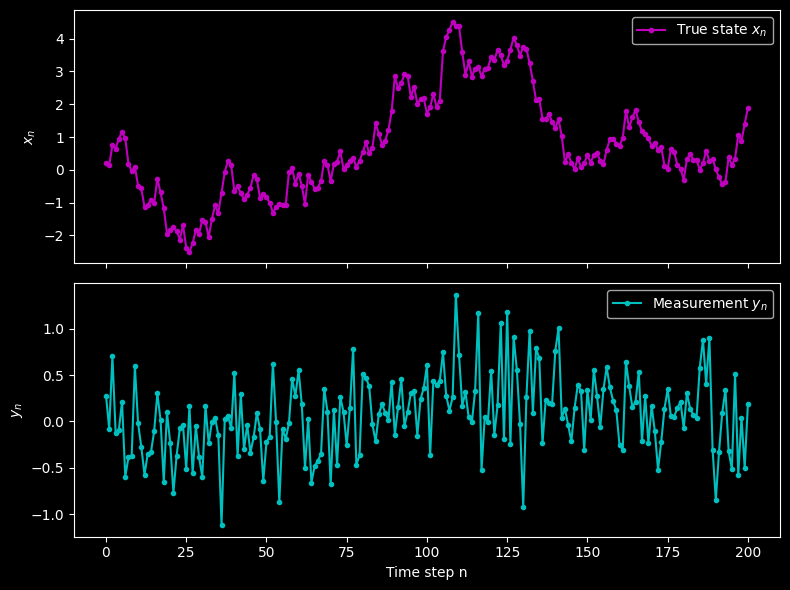

In [59]:
# True state x_n and measurements y_n
fig_1, ax_1 = plt.subplots(2, 1, sharex=True, figsize=(8,6))

ax_1[0].plot(range(n_step), x_true, 'm.-', label='True state $x_n$')
ax_1[0].set_ylabel('$x_n$')
ax_1[0].legend(loc='best')

ax_1[1].plot(range(n_step), y, 'c.-', label='Measurement $y_n$')
ax_1[1].set_xlabel('Time step n')
ax_1[1].set_ylabel('$y_n$')
ax_1[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [60]:
xp = np.zeros((n_particle, n_step)) # particles
wp = np.zeros((n_particle, n_step)) # weights
posterior_pdf = np.zeros((n_particle, n_step)) # posterior density
x_grid = np.linspace(x_min, x_max, n_particle)
width  = x_grid[1] - x_grid[0]

x_mode = np.zeros(n_step)
x_mean = np.zeros(n_step)
x_median = np.zeros(n_step)
x_lower = np.zeros(n_step)
x_upper = np.zeros(n_step)
n_particle_eff = np.zeros(n_step)

# grid edges for histogram
edges = np.concatenate((
    [x_grid[0] - width/2],
    (x_grid[:-1] + x_grid[1:]) / 2,
    [x_grid[-1] + width/2]
))

def get_median_cl(xp, wp, n):
    sort_idx = np.argsort(xp[:, n])
    xp_sorted = xp[sort_idx, n]
    wp_sorted = wp[sort_idx, n]
    cdf = np.cumsum(wp_sorted)

    x_median = xp_sorted[np.searchsorted(cdf, 0.5)]
    x_lower = xp_sorted[np.searchsorted(cdf, 0.025)]
    x_upper = xp_sorted[min(np.searchsorted(cdf, 0.975), n_particle - 1)]

    return x_median, x_lower, x_upper

Initial step

In [61]:
# prior at step 0
# uniform distribution of particle over (x_min, x_max)
xp[:, 0] = np.random.rand(n_particle) * (x_max - x_min) + x_min
wp[:, 0] = np.full(n_particle, 1.0 / n_particle) # equal weights

# first filter using y[0] to get posterior at step 0
likelihood_0 = norm.pdf(y[0], loc=h_n(xp[:, 0]), scale=sigma_v)
wp[:, 0] *= likelihood_0
wp[:, 0] /= wp[:, 0].sum()

n_particle_eff[0] = 1.0 / np.sum(wp[:, 0]**2)

hist = np.histogram(xp[:, 0], bins=edges, weights=wp[:, 0])[0]
posterior_pdf[:, 0] = hist / width

x_mean[0] = np.sum(wp[:, 0] * xp[:, 0])
x_mode[0] = xp[np.argmax(wp[:, 0]), 0]

x_median[0], x_lower[0], x_upper[0] = get_median_cl(xp, wp, 0)

print(x_mean[0])
print(x_mode[0])
print(x_median[0])
print(x_lower[0])
print(x_upper[0])

print(sum(hist))

0.9639010273063093
2.7552761669501056
1.1062004244163255
-3.9821752737959626
4.694704332753689
0.9999999999999991


Main loop

In [62]:
for n in range(1, n_step):
    # propagate particles, that is q(x_n|x_n-1) = N(f(x_n-1), sigma_u^2)
    # unlike bayesian filtering earlier, we don't need to get q from all x_n-1
    # but only corresponding one, so easier to use process model rather than norm.pdf()
    xp[:, n] = f_n(xp[:, n-1]) + np.random.randn(n_particle) * sigma_u # (n_partcile,)

    # likelihood given observed y[n]
    likelihood = norm.pdf(y[n], loc=h_n(xp[:, n]), scale=sigma_v) # (n_partcile,)

    wp[:, n] = likelihood * wp[:, n-1] # unnormalized weights
    wp_sum = wp[:, n].sum()

    if wp_sum == 0:
        # all weights underflowed re-initialize
        wp[:, n] = 1.0 / n_particle
    else:
        wp[:, n] /= wp_sum

    n_particle_eff[n] = 1.0 / np.sum(wp[:, n]**2)

    # resampling would be added later

    # histogram to approximate pdf on fixed grid
    hist = np.histogram(xp[:, n], bins=edges, weights=wp[:, n])[0]
    posterior_pdf[:, n] = hist / width

    # summary statistics
    x_mean[n] = np.sum(wp[:, n] * xp[:, n])
    x_mode[n] = xp[np.argmax(wp[:, n]), n]

    x_median[n], x_lower[n], x_upper[n] = get_median_cl(xp, wp, n)

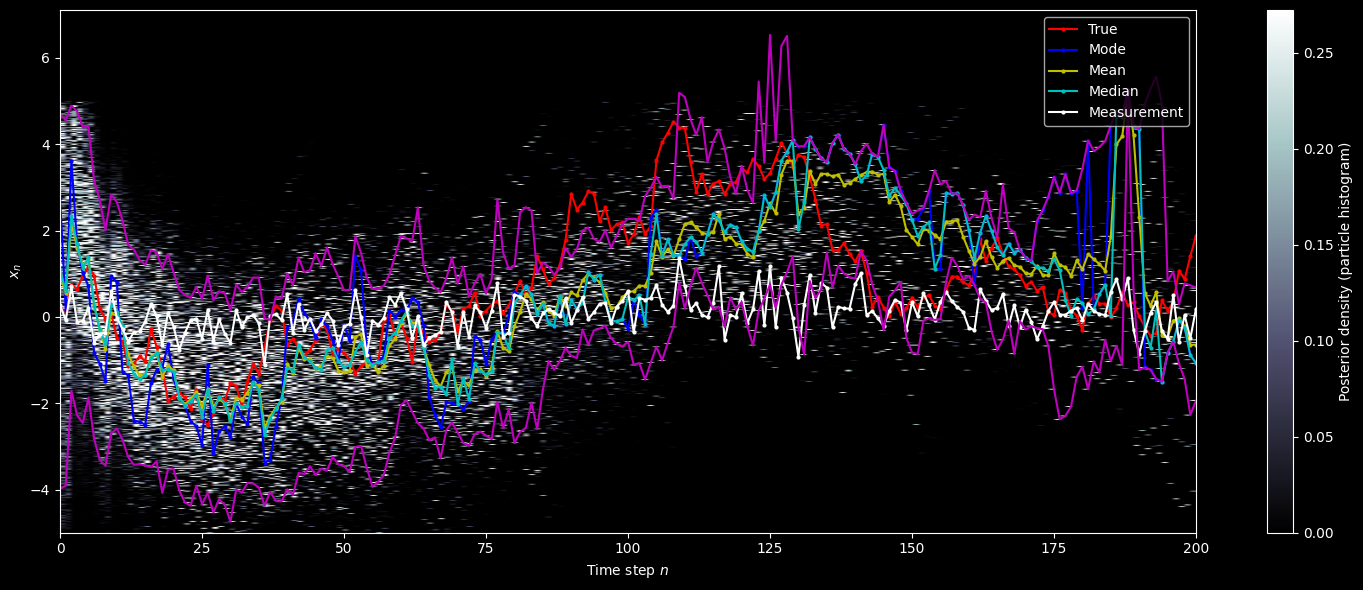

In [63]:
fig_2, ax_2 = plt.subplots(figsize=(15, 6))

im = ax_2.imshow(
    posterior_pdf,
    origin='lower',
    aspect='auto',
    extent=[0, n_step - 1, x_min, x_max],
    cmap='bone'
)

cmax = np.percentile(posterior_pdf, 95)
im.set_clim([0, cmax])

n_grid = np.arange(n_step)
ax_2.plot(n_grid, x_true, 'r.-', label='True', markersize=4)
ax_2.plot(n_grid, x_mode, 'b.-', label='Mode', markersize=4)
ax_2.plot(n_grid, x_mean, 'y.-', label='Mean', markersize=4)
ax_2.plot(n_grid, x_median, 'c.-', label='Median', markersize=4)
ax_2.plot(n_grid, y, 'w.-', label='Measurement', markersize=4)

ax_2.plot(n_grid, x_lower, 'm')
ax_2.plot(n_grid, x_upper, 'm')

ax_2.set_xlabel('Time step $n$')
ax_2.set_ylabel('$x_n$')

cbar = plt.colorbar(im)
cbar.set_label('Posterior density (particle histogram)')

ax_2.legend(loc='upper right')
plt.tight_layout()
plt.show()

Degeneracy cues

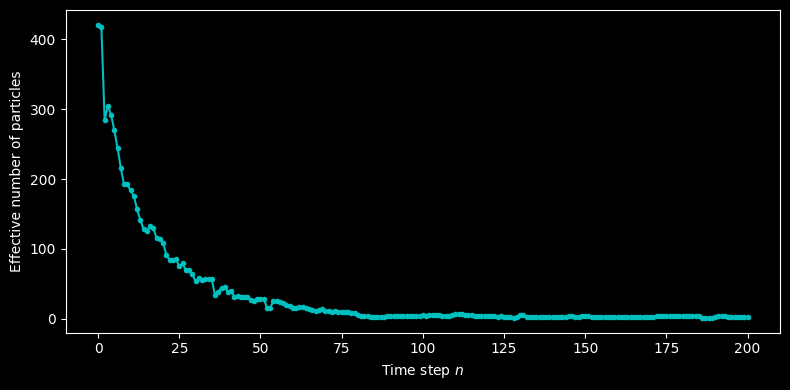

In [64]:
# plot effective number of particles
fig_3, ax_3 = plt.subplots(figsize=(8, 4))

ax_3.plot(n_grid, n_particle_eff, 'c.-')
ax_3.set_xlabel('Time step $n$')
ax_3.set_ylabel('Effective number of particles')

plt.tight_layout()
plt.show()